# 0. Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

# 1. Load Dataset

In [2]:
df = pd.read_csv("/kaggle/input/datasets/saifewu/mall-customers/Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# 2. Preprocessing and Feature Engineering

In [3]:
df_unsupervised = df.drop(columns=['CustomerID'])

df_unsupervised['Gender'] = df_unsupervised['Gender'].map({'Male': 0, 'Female': 1})

categorical_features = ['Gender']
numerical_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_unsupervised)

processed_data_df = pd.DataFrame(scaled_data, columns=df_unsupervised.columns)

processed_data_df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,-1.128152,-1.424569,-1.738999,-0.434801
1,-1.128152,-1.281035,-1.738999,1.195704
2,0.886405,-1.352802,-1.700830,-1.715913
3,0.886405,-1.137502,-1.700830,1.040418
4,0.886405,-0.563369,-1.662660,-0.395980


# 3. Elbow Method

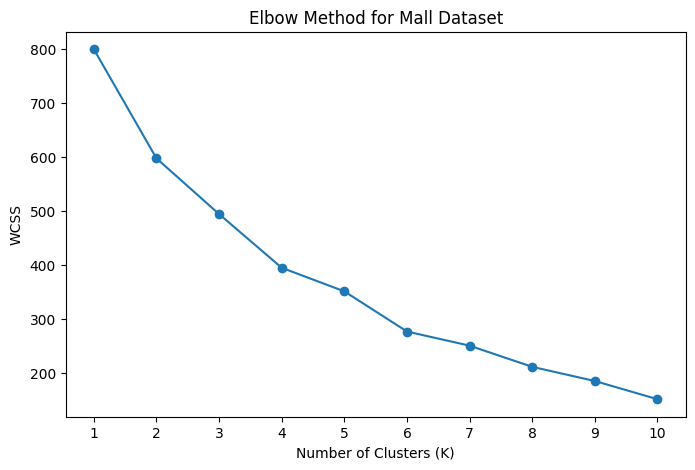

In [4]:
wcss = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(processed_data_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_range, wcss, marker='o')
plt.title("Elbow Method for Mall Dataset")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.xticks(k_range)
plt.show()

# 4. Apply Clustering

In [5]:
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, max_iter=300, random_state=42)
processed_data_df['KMeans_Cluster'] = kmeans.fit_predict(processed_data_df)

dbscan = DBSCAN(eps=0.7, min_samples=5)
processed_data_df['DBSCAN_Cluster'] = dbscan.fit_predict(
    processed_data_df.drop(columns=['KMeans_Cluster'])
)

gmm = GaussianMixture(n_components=n_clusters, random_state=42)
processed_data_df['GMM_Cluster'] = gmm.fit_predict(
    processed_data_df.drop(columns=['KMeans_Cluster', 'DBSCAN_Cluster'])
)

# 5. Evaluation Metrics

In [6]:
feature_data = processed_data_df.drop(
    columns=['KMeans_Cluster', 'DBSCAN_Cluster', 'GMM_Cluster']
)

silhouette_kmeans = silhouette_score(feature_data, processed_data_df['KMeans_Cluster'])
dbi_kmeans = davies_bouldin_score(feature_data, processed_data_df['KMeans_Cluster'])

print("KMeans Silhouette Score:", silhouette_kmeans)
print("KMeans Davies-Bouldin Index:", dbi_kmeans)

if len(set(processed_data_df['DBSCAN_Cluster'])) > 1:
    silhouette_dbscan = silhouette_score(feature_data, processed_data_df['DBSCAN_Cluster'])
    dbi_dbscan = davies_bouldin_score(feature_data, processed_data_df['DBSCAN_Cluster'])

    print("DBSCAN Silhouette Score:", silhouette_dbscan)
    print("DBSCAN Davies-Bouldin Index:", dbi_dbscan)
else:
    print("DBSCAN did not form valid clusters.")

silhouette_gmm = silhouette_score(feature_data, processed_data_df['GMM_Cluster'])
dbi_gmm = davies_bouldin_score(feature_data, processed_data_df['GMM_Cluster'])

print("GMM Silhouette Score:", silhouette_gmm)
print("GMM Davies-Bouldin Index:", dbi_gmm)

KMeans Silhouette Score: 0.27191023466188324
KMeans Davies-Bouldin Index: 1.181091452406171
DBSCAN Silhouette Score: 0.14190497030817678
DBSCAN Davies-Bouldin Index: 1.6805103123035896
GMM Silhouette Score: 0.2216401485402198
GMM Davies-Bouldin Index: 1.2106137671043733


# 6. Visualization with PCA

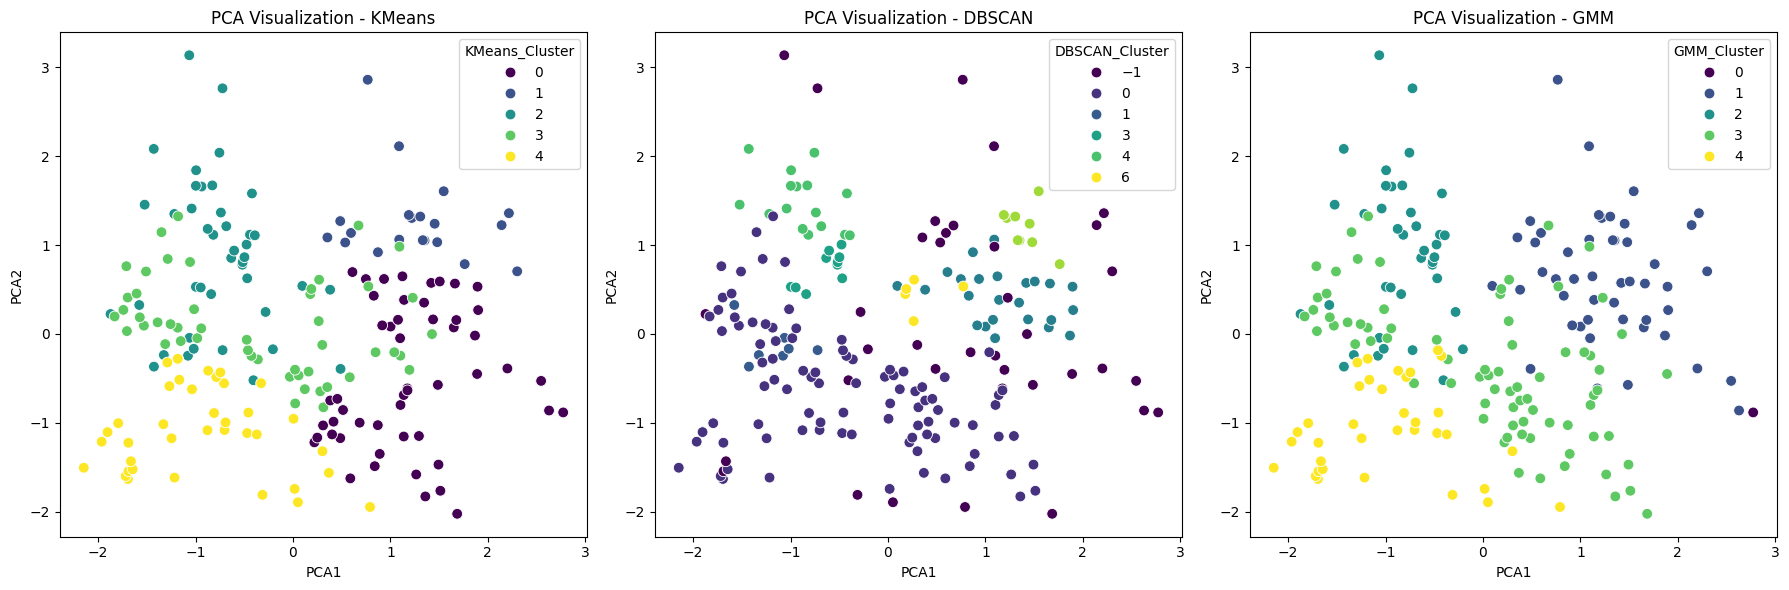

In [7]:
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(feature_data)

processed_data_df['PCA1'] = pca_result[:, 0]
processed_data_df['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
sns.scatterplot(data=processed_data_df, x='PCA1', y='PCA2',
                hue='KMeans_Cluster', palette='viridis', s=60)
plt.title("PCA Visualization - KMeans")

plt.subplot(1,3,2)
sns.scatterplot(data=processed_data_df, x='PCA1', y='PCA2',
                hue='DBSCAN_Cluster', palette='viridis', s=60)
plt.title("PCA Visualization - DBSCAN")

plt.subplot(1,3,3)
sns.scatterplot(data=processed_data_df, x='PCA1', y='PCA2',
                hue='GMM_Cluster', palette='viridis', s=60)
plt.title("PCA Visualization - GMM")

plt.tight_layout()
plt.show()

# 7. Visualization using t-SNE

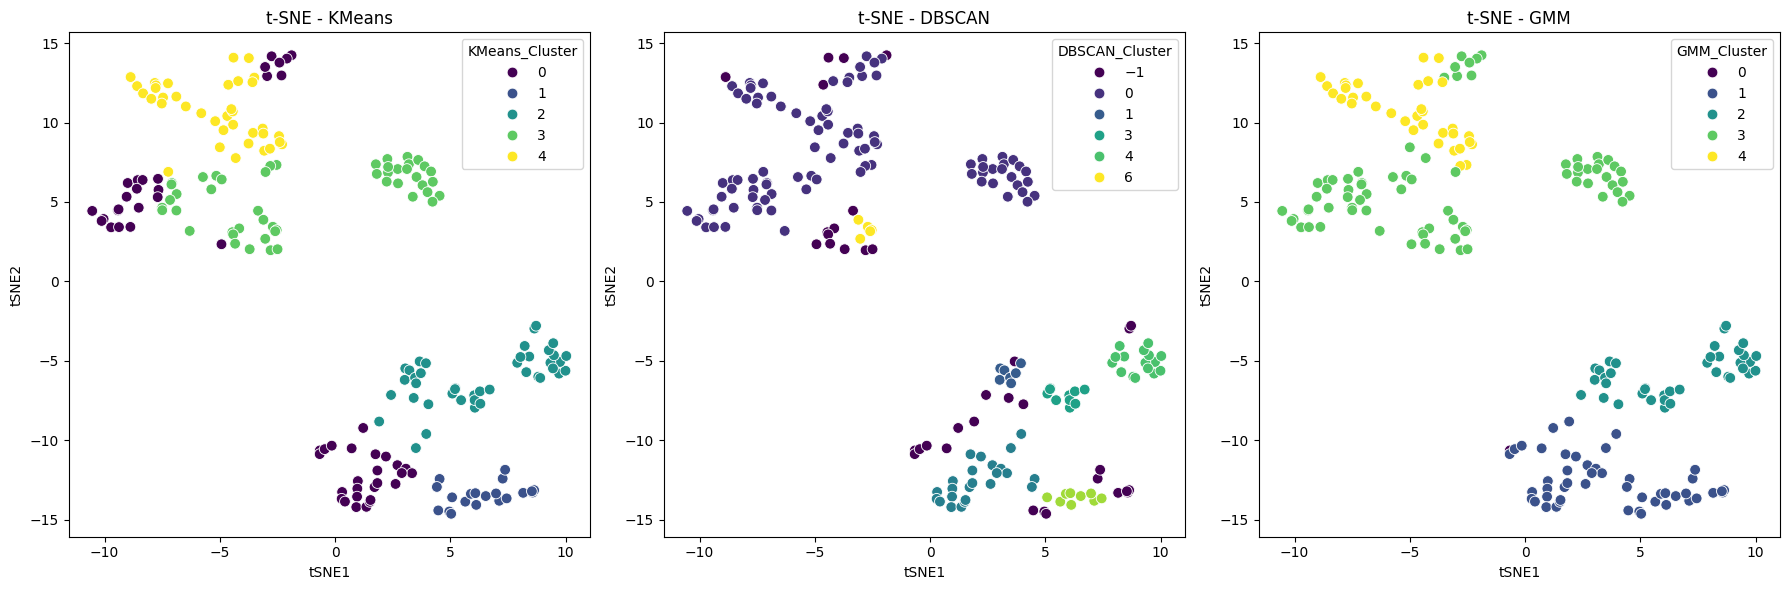

In [8]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(feature_data)

processed_data_df['tSNE1'] = tsne_result[:, 0]
processed_data_df['tSNE2'] = tsne_result[:, 1]

plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
sns.scatterplot(data=processed_data_df, x='tSNE1', y='tSNE2',
                hue='KMeans_Cluster', palette='viridis', s=60)
plt.title("t-SNE - KMeans")

plt.subplot(1,3,2)
sns.scatterplot(data=processed_data_df, x='tSNE1', y='tSNE2',
                hue='DBSCAN_Cluster', palette='viridis', s=60)
plt.title("t-SNE - DBSCAN")

plt.subplot(1,3,3)
sns.scatterplot(data=processed_data_df, x='tSNE1', y='tSNE2',
                hue='GMM_Cluster', palette='viridis', s=60)
plt.title("t-SNE - GMM")

plt.tight_layout()
plt.show()